In [1]:
# ============================================================
# Notebook 02 — Data Preprocessing & Augmentation
# ------------------------------------------------------------
# Prepare dataset transforms, Dataset classes, and utilities
# for training. Includes augmentation pipelines, data loaders,
# and quick visualization helpers.
# ============================================================

# -------------------------
# 1. Setup & Imports
# -------------------------
# Core libs, image I/O, numeric ops, plotting, and PyTorch.
import os
import sys
import cv2                     # image reading & resizing
import numpy as np            # numerical ops
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import albumentations as A    # augmentation library
from albumentations.pytorch import ToTensorV2
import warnings
warnings.filterwarnings('ignore')  # reduce noise in notebook output

# Quick sanity prints to confirm environment
print("✅ Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


✅ Libraries imported successfully!
PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: NVIDIA GeForce RTX 4050 Laptop GPU


In [2]:
# ============================================================
# 2. Configuration (WINDOWS-FIXED VERSION)
# ------------------------------------------------------------
# Centralized configuration for preprocessing notebook.
# Includes dataset paths, training params, Windows-safe DataLoader
# setting (NUM_WORKERS=0) and visualization paths.
# ============================================================

class Config:
    """Project configuration (update BASE_DIR if needed)."""
    BASE_DIR = Path(r"D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation")

    # -------------------------
    # Data paths
    # -------------------------
    RAW_DATA     = BASE_DIR / "data" / "raw" / "FloodNet"
    TRAIN_IMAGES = RAW_DATA / "train" / "train-org-img"
    TRAIN_MASKS  = RAW_DATA / "train" / "train-label-img"
    VAL_IMAGES   = RAW_DATA / "val" / "val-org-img"
    VAL_MASKS    = RAW_DATA / "val" / "val-label-img"

    # -------------------------
    # Output / visualization
    # -------------------------
    RESULTS_DIR = BASE_DIR / "results"
    VIZ_DIR     = RESULTS_DIR / "visualizations" / "preprocessing"

    # -------------------------
    # Training / preprocessing params
    # -------------------------
    IMG_HEIGHT  = 256
    IMG_WIDTH   = 256
    BATCH_SIZE  = 8
    NUM_CLASSES = 10

    # -------------------------
    # Windows-specific fix
    # -------------------------
    # On Windows, DataLoader workers > 0 can cause issues in some setups.
    # Set NUM_WORKERS = 0 to avoid multiprocessing problems when running locally.
    if os.name == 'nt':  # 'nt' indicates Windows platform
        NUM_WORKERS = 0
        print("Windows detected → num_workers = 0 (prevents DataLoader crash)")
    else:
        NUM_WORKERS = 4

    # -------------------------
    # Class metadata
    # -------------------------
    CLASS_NAMES = [
        "Background", "Building-flooded", "Building-non-flooded",
        "Road-flooded", "Road-non-flooded", "Water",
        "Tree", "Vehicle", "Pool", "Grass"
    ]

    # RGB colors used for mask visualization (0-255)
    CLASS_COLORS = {
        0: (0, 0, 0),       1: (255, 0, 0),     2: (0, 0, 255),
        3: (255, 165, 0),   4: (128, 128, 128), 5: (0, 255, 255),
        6: (0, 255, 0),     7: (255, 0, 255),   8: (255, 255, 255),
        9: (0, 128, 0)
    }


# -------------------------
# Ensure visualization directory exists and print concise summary
# -------------------------
Config.VIZ_DIR.mkdir(parents=True, exist_ok=True)

print("=" * 60)
print("PREPROCESSING CONFIGURATION (WINDOWS-SAFE)")
print("=" * 60)
print(f"Image Size: {Config.IMG_HEIGHT}x{Config.IMG_WIDTH}")
print(f"Batch Size: {Config.BATCH_SIZE}")
print(f"Workers: {Config.NUM_WORKERS} ← Windows-safe setting")
print("=" * 60)


Windows detected → num_workers = 0 (prevents DataLoader crash)
PREPROCESSING CONFIGURATION (WINDOWS-SAFE)
Image Size: 256x256
Batch Size: 8
Workers: 0 ← Windows-safe setting


In [3]:
# ============================================================
# 3. Dataset Class — FloodNetDataset
# ------------------------------------------------------------
# Custom PyTorch Dataset for loading RGB images and their
# corresponding segmentation masks. Supports FloodNet naming
# variations and Albumentations transforms.
# ============================================================

class FloodNetDataset(Dataset):
    """
    Pytorch Dataset for FloodNet.

    Args:
        image_dir (Path): directory containing RGB images
        mask_dir (Path): directory containing mask images
        transform (A.Compose | None): Albumentations augmentation pipeline
        img_size (tuple): resized output dimension (H, W)
    """
    
    def __init__(self, image_dir, mask_dir, transform=None, img_size=(256, 256)):
        self.image_dir = Path(image_dir)
        self.mask_dir  = Path(mask_dir)
        self.transform = transform
        self.img_size  = img_size

        # Collect all valid image files
        self.images = sorted([
            f for f in self.image_dir.glob("*")
            if f.suffix.lower() in [".jpg", ".jpeg", ".png"]
        ])

        print(f"📂 Loaded {len(self.images)} images from {image_dir.name}")

    def __len__(self):
        """Return total number of images."""
        return len(self.images)

    def _find_mask_path(self, image_path):
        """Find matching mask file based on stem and known FloodNet patterns."""
        
        stem = image_path.stem
        patterns = [
            f"{stem}.png",
            f"{stem}_lab.png",
            f"{stem}_mask.png",
        ]

        # Try exact patterns
        for p in patterns:
            candidate = self.mask_dir / p
            if candidate.exists():
                return candidate
        
        # Fallback: search any containing filename
        for m in self.mask_dir.glob(f"*{stem}*"):
            return m
        
        return None

    def __getitem__(self, idx):
        """Load, preprocess, augment, and convert image + mask."""

        img_path = self.images[idx]

        # ---- Load image (BGR → RGB) ----
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # ---- Load mask ----
        mask_path = self._find_mask_path(img_path)
        if mask_path and mask_path.exists():
            mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        else:
            print(f"⚠️ Mask not found for {img_path.name}")
            mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

        # ---- Resize data ----
        image = cv2.resize(image, self.img_size, interpolation=cv2.INTER_LINEAR)
        mask  = cv2.resize(mask,  self.img_size, interpolation=cv2.INTER_NEAREST)

        # ---- Albumentations augmentations ----
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]
        else:
            # Default conversion (no augmentations)
            image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
            mask  = torch.from_numpy(mask).long()

        # ---- Ensure mask is Long tensor ----
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask)
        mask = mask.long()

        return image, mask


print("✅ FloodNetDataset class defined")


✅ FloodNetDataset class defined


In [4]:
# ============================================================
# 4. Augmentation Pipelines
# ------------------------------------------------------------
# Albumentations transforms for training and validation.
# Training pipeline includes geometric, color, and noise
# augmentations to increase dataset variability.
# Validation pipeline applies only normalization + tensor conversion.
# ============================================================

def get_train_transform(img_size=(256, 256)):
    """
    Augmentation pipeline for training.
    Includes flips, rotation, scaling, color jitter, noise/blur,
    normalization, and conversion to PyTorch tensors.
    """
    return A.Compose([
        # --- Geometric transforms ---
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.1,
            scale_limit=0.15,
            rotate_limit=30,
            p=0.5,
            border_mode=cv2.BORDER_CONSTANT,  # fill empty pixels with constants
            value=0,
            mask_value=0
        ),

        # --- Color adjustments (image only) ---
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=1),
            A.RandomGamma(gamma_limit=(80, 120), p=1),
        ], p=0.5),

        # --- Noise/Blur augmentations ---
        A.OneOf([
            A.GaussNoise(var_limit=(10.0, 30.0), p=1),
            A.GaussianBlur(blur_limit=(3, 5), p=1),
            A.MedianBlur(blur_limit=3, p=1),
        ], p=0.2),

        # --- Normalize using ImageNet mean/std ---
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225),
            max_pixel_value=255.0
        ),

        # --- Convert to torch.Tensor ---
        ToTensorV2(),
    ])


def get_val_transform(img_size=(256, 256)):
    """
    Validation preprocessing.
    No augmentations → only normalization + tensor conversion.
    """
    return A.Compose([
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225),
            max_pixel_value=255.0
        ),
        ToTensorV2(),
    ])


print("✅ Augmentation pipelines defined")


✅ Augmentation pipelines defined


In [5]:
# ============================================================
# 5. Create Datasets and DataLoaders
# ------------------------------------------------------------
# Initialize FloodNetDataset instances for training and validation,
# then wrap them in PyTorch DataLoaders with proper batching and
# Windows-safe worker configuration.
# ============================================================

print("\n" + "=" * 60)
print("📊 CREATING DATASETS")
print("=" * 60)

# -------------------------
# Training dataset
# -------------------------
train_dataset = FloodNetDataset(
    Config.TRAIN_IMAGES,
    Config.TRAIN_MASKS,
    transform=get_train_transform((Config.IMG_HEIGHT, Config.IMG_WIDTH)),
    img_size=(Config.IMG_HEIGHT, Config.IMG_WIDTH)
)

# -------------------------
# Validation dataset
# -------------------------
val_dataset = FloodNetDataset(
    Config.VAL_IMAGES,
    Config.VAL_MASKS,
    transform=get_val_transform((Config.IMG_HEIGHT, Config.IMG_WIDTH)),
    img_size=(Config.IMG_HEIGHT, Config.IMG_WIDTH)
)

# -------------------------
# DataLoaders (Windows-safe)
# -------------------------
train_loader = DataLoader(
    train_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=True,
    num_workers=Config.NUM_WORKERS,  # Windows → 0 workers
    pin_memory=True,
    drop_last=True                   # ensures full batches
)

val_loader = DataLoader(
    val_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False,
    num_workers=Config.NUM_WORKERS,
    pin_memory=True
)

# Summary
print(f"\n✅ Datasets created:")
print(f"   Training:   {len(train_dataset):5d} images ({len(train_loader):4d} batches)")
print(f"   Validation: {len(val_dataset):5d} images ({len(val_loader):4d} batches)")



📊 CREATING DATASETS
📂 Loaded 1445 images from train-org-img
📂 Loaded 450 images from val-org-img

✅ Datasets created:
   Training:    1445 images ( 180 batches)
   Validation:   450 images (  57 batches)


In [6]:
# ============================================================
# 6. Test Data Loading
# ------------------------------------------------------------
# Quick runtime checks to ensure DataLoader yields properly
# shaped tensors, correct dtypes/ranges, and reasonable class
# distribution within a sample batch.
# ============================================================

print("\n" + "=" * 60)
print("🧪 TESTING DATA LOADING")
print("=" * 60)

# ---- Fetch a single batch from the training loader ----
sample_images, sample_masks = next(iter(train_loader))

# ---- Basic sanity prints ----
print(f"\n✅ Successfully loaded batch:")
print(f"   Images shape: {sample_images.shape}")           # (B, C, H, W)
print(f"   Images dtype: {sample_images.dtype}")
print(f"   Images range: [{sample_images.min():.3f}, {sample_images.max():.3f}]")

print(f"\n   Masks shape: {sample_masks.shape}")            # (B, H, W)
print(f"   Masks dtype: {sample_masks.dtype}")
print(f"   Masks range: [{sample_masks.min()}, {sample_masks.max()}]")
print(f"   Unique classes: {torch.unique(sample_masks).tolist()}")

# ---- Class distribution within the sampled batch ----
unique, counts = torch.unique(sample_masks, return_counts=True)
print(f"\n📊 Class distribution in sample batch:")
total_pixels = sample_masks.numel()  # total number of pixels in the batch

for cls, count in zip(unique.tolist(), counts.tolist()):
    pct = count / total_pixels * 100
    cls_name = Config.CLASS_NAMES[cls] if cls < len(Config.CLASS_NAMES) else f"Class_{cls}"
    print(f"   Class {cls} ({cls_name:20s}): {count:7d} pixels ({pct:5.2f}%)")


🧪 TESTING DATA LOADING

✅ Successfully loaded batch:
   Images shape: torch.Size([8, 3, 256, 256])
   Images dtype: torch.float32
   Images range: [-2.118, 2.640]

   Masks shape: torch.Size([8, 256, 256])
   Masks dtype: torch.int64
   Masks range: [0, 9]
   Unique classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

📊 Class distribution in sample batch:
   Class 0 (Background          ):   79088 pixels (15.08%)
   Class 1 (Building-flooded    ):   15249 pixels ( 2.91%)
   Class 2 (Building-non-flooded):   28662 pixels ( 5.47%)
   Class 3 (Road-flooded        ):   22883 pixels ( 4.36%)
   Class 4 (Road-non-flooded    ):   28665 pixels ( 5.47%)
   Class 5 (Water               ):   72060 pixels (13.74%)
   Class 6 (Tree                ):   84509 pixels (16.12%)
   Class 7 (Vehicle             ):    1465 pixels ( 0.28%)
   Class 8 (Pool                ):    1122 pixels ( 0.21%)
   Class 9 (Grass               ):  190585 pixels (36.35%)



🎨 VISUALIZING AUGMENTED TRAINING DATA
💾 Saved to: D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation\results\visualizations\preprocessing\training_augmented_samples.png


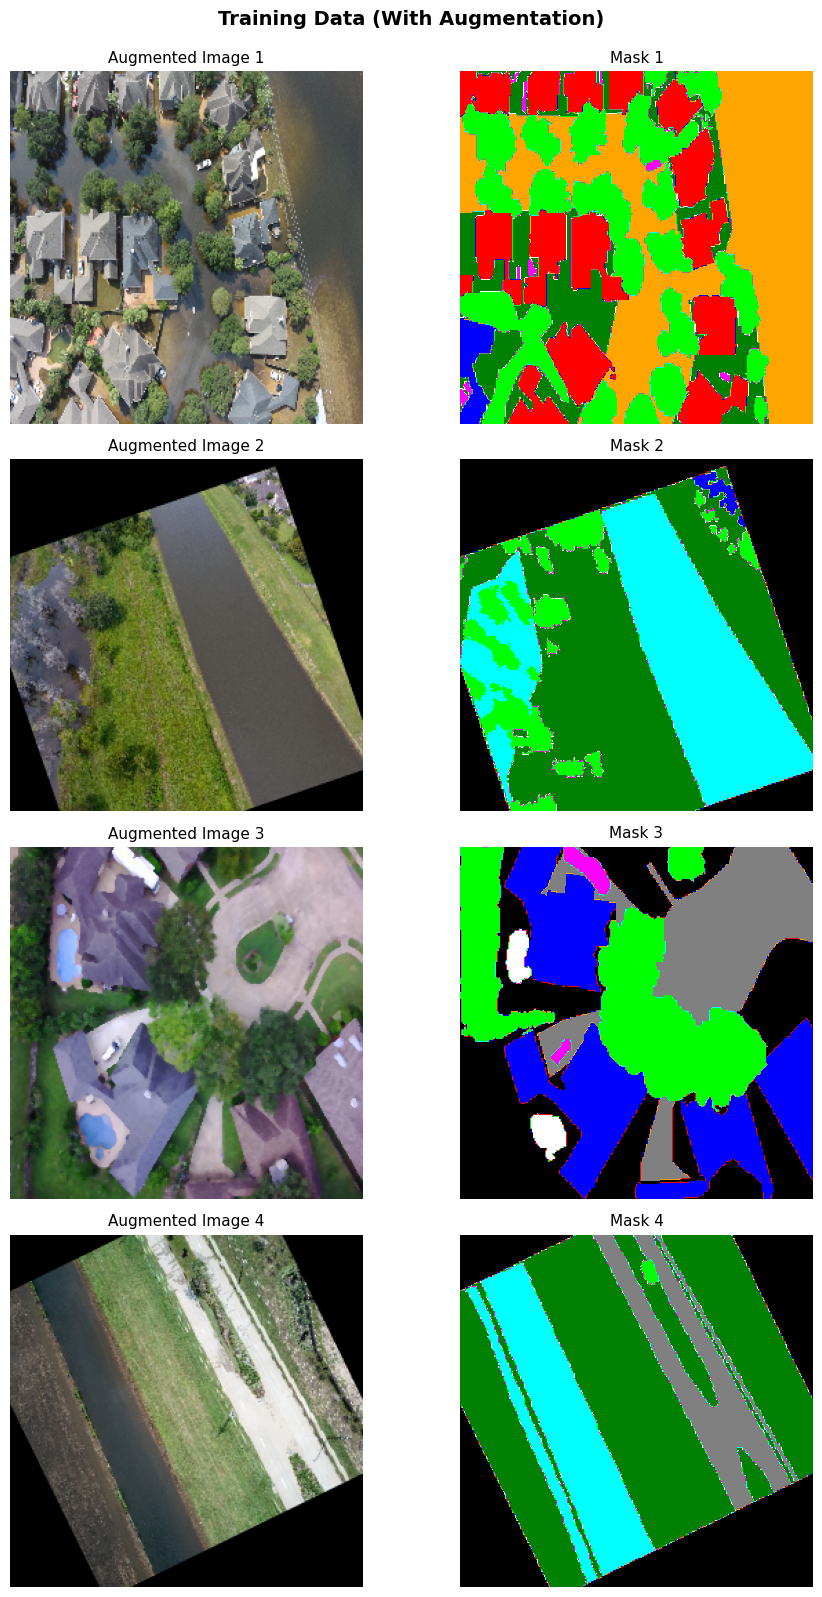

In [7]:
# ============================================================
# 7. Visualize Augmentations
# ------------------------------------------------------------
# Utilities to denormalize tensors, create a consistent colormap,
# and visualize augmented image/mask batches for quick sanity checks.
# ============================================================

import matplotlib.colors as mcolors

# Normalize class colors to [0,1] for matplotlib
CLASS_COLORS_NORMALIZED = {
    i: tuple(c / 255.0 for c in Config.CLASS_COLORS[i])
    for i in range(Config.NUM_CLASSES)
}
colors_list = [CLASS_COLORS_NORMALIZED[i] for i in range(Config.NUM_CLASSES)]
custom_cmap = mcolors.ListedColormap(colors_list)  # consistent mask coloring


def denormalize_image(img_tensor):
    """
    Denormalize an image tensor (C, H, W) using ImageNet mean/std
    and convert to HxWxC numpy array in range [0, 1] for plotting.
    """
    # ImageNet normalization values used in augmentations
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    # Move to CPU, reverse normalization, and convert to HWC numpy
    img = img_tensor.cpu() * std + mean
    img = img.permute(1, 2, 0).numpy()
    return np.clip(img, 0.0, 1.0)  # ensure valid display range


def visualize_batch(images, masks, num_samples=4, title="Batch Visualization", save_path=None):
    """
    Visualize a batch of images and their corresponding masks.

    Args:
        images (Tensor): batch of image tensors (B, C, H, W) normalized.
        masks (Tensor): batch of mask tensors (B, H, W) with class ids.
        num_samples (int): number of samples to display from the batch.
        title (str): figure title.
        save_path (Path|None): optional path to save the figure.
    """
    # Limit to available samples
    num_samples = min(num_samples, len(images))
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4 * num_samples))

    # Ensure axes shape is consistent for single-sample case
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        # Prepare display image and mask
        img = denormalize_image(images[i])        # (H, W, C) in [0,1]
        mask = masks[i].cpu().numpy()            # (H, W) integer class ids

        # Left: augmented image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Augmented Image {i + 1}", fontsize=11)
        axes[i, 0].axis("off")

        # Right: mask (colored by custom colormap)
        axes[i, 1].imshow(mask, cmap=custom_cmap, vmin=0, vmax=Config.NUM_CLASSES - 1)
        axes[i, 1].set_title(f"Mask {i + 1}", fontsize=11)
        axes[i, 1].axis("off")

    # Global title and layout
    fig.suptitle(title, fontsize=14, fontweight="bold", y=0.995)
    plt.tight_layout()

    # Save figure if requested
    if save_path:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"💾 Saved to: {save_path}")

    plt.show()


# -------------------------
# Run visualization on a sample batch
# -------------------------
print("\n" + "=" * 60)
print("🎨 VISUALIZING AUGMENTED TRAINING DATA")
print("=" * 60)

visualize_batch(
    sample_images, sample_masks,
    num_samples=4,
    title="Training Data (With Augmentation)",
    save_path=Config.VIZ_DIR / "training_augmented_samples.png"
)



🔄 COMPARING ORIGINAL VS AUGMENTED
📂 Loaded 1445 images from train-org-img
💾 Saved to: D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation\results\visualizations\preprocessing\augmentation_comparison.png


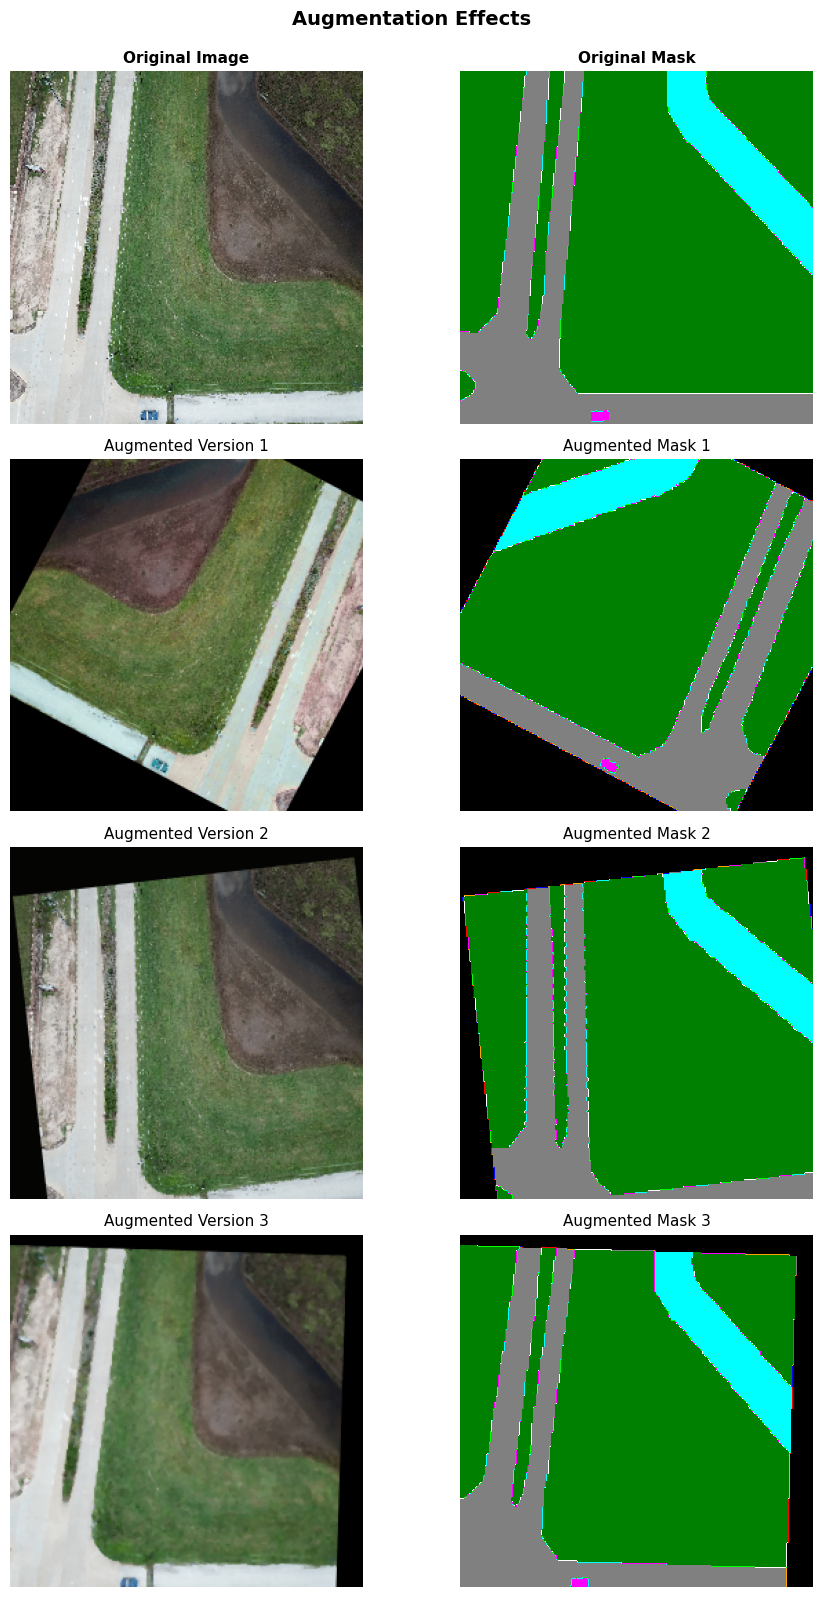

In [ ]:
# ============================================================
# 8. Compare Original vs Augmented
# ------------------------------------------------------------
# Visual check: display the original image + mask and several
# augmented variations produced by the training dataset pipeline.
# Useful for verifying that geometric/color transforms preserve
# label integrity and look realistic.
# ============================================================

def visualize_augmentation_effects(dataset, num_samples=3, save_path=None):
    """
    Show multiple augmentations of a single randomly selected image.
    
    Args:
        dataset (Dataset): dataset instance that applies augmentations
                           (e.g., train_dataset with get_train_transform).
        num_samples (int): number of augmented variants to display.
        save_path (Path|str|None): optional path to save the figure.
    """
    # Create a dataset variant without augmentation to get the original image
    dataset_no_aug = FloodNetDataset(
        dataset.image_dir,
        dataset.mask_dir,
        transform=get_val_transform((Config.IMG_HEIGHT, Config.IMG_WIDTH)),  # no augmentations
        img_size=(Config.IMG_HEIGHT, Config.IMG_WIDTH)
    )

    # Pick a random index from the dataset
    idx = np.random.randint(0, len(dataset))

    # Load original (no-augmentation) image + mask and denormalize for display
    orig_img, orig_mask = dataset_no_aug[idx]
    orig_img = denormalize_image(orig_img)         # convert tensor -> HWC [0,1]
    orig_mask = orig_mask.cpu().numpy()            # mask as numpy array

    # Prepare figure with one row for original + rows for augmented versions
    fig, axes = plt.subplots(num_samples + 1, 2, figsize=(10, 4 * (num_samples + 1)))
    if num_samples == 0:
        # ensure axes shape is consistent if user passes num_samples=0
        axes = axes.reshape(1, 2)

    # Row 0: Original image and mask
    axes[0, 0].imshow(orig_img)
    axes[0, 0].set_title("Original Image", fontsize=11, fontweight="bold")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(orig_mask, cmap=custom_cmap, vmin=0, vmax=Config.NUM_CLASSES - 1)
    axes[0, 1].set_title("Original Mask", fontsize=11, fontweight="bold")
    axes[0, 1].axis("off")

    # Subsequent rows: Different augmented draws from the training dataset
    for i in range(num_samples):
        aug_img, aug_mask = dataset[idx]            # dataset applies augmentation at __getitem__
        aug_img = denormalize_image(aug_img)
        aug_mask = aug_mask.cpu().numpy()

        axes[i + 1, 0].imshow(aug_img)
        axes[i + 1, 0].set_title(f"Augmented Version {i + 1}", fontsize=11)
        axes[i + 1, 0].axis("off")

        axes[i + 1, 1].imshow(aug_mask, cmap=custom_cmap, vmin=0, vmax=Config.NUM_CLASSES - 1)
        axes[i + 1, 1].set_title(f"Augmented Mask {i + 1}", fontsize=11)
        axes[i + 1, 1].axis("off")

    # Overall title and layout
    fig.suptitle("Augmentation Effects", fontsize=14, fontweight="bold", y=0.995)
    plt.tight_layout()

    # Optionally save the figure
    if save_path:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"💾 Saved to: {save_path}")

    plt.show()


# -------------------------
# Execute comparison visualization
# -------------------------
print("\n" + "=" * 60)
print("🔄 COMPARING ORIGINAL VS AUGMENTED")
print("=" * 60)

visualize_augmentation_effects(
    train_dataset,
    num_samples=3,
    save_path=Config.VIZ_DIR / "augmentation_comparison.png"
)



📊 VISUALIZING VALIDATION DATA (NO AUGMENTATION)
💾 Saved to: D:\Projects\Image_Segmentation_for_Disaster_Resilience\Disaster-segmentation\results\visualizations\preprocessing\validation_samples.png


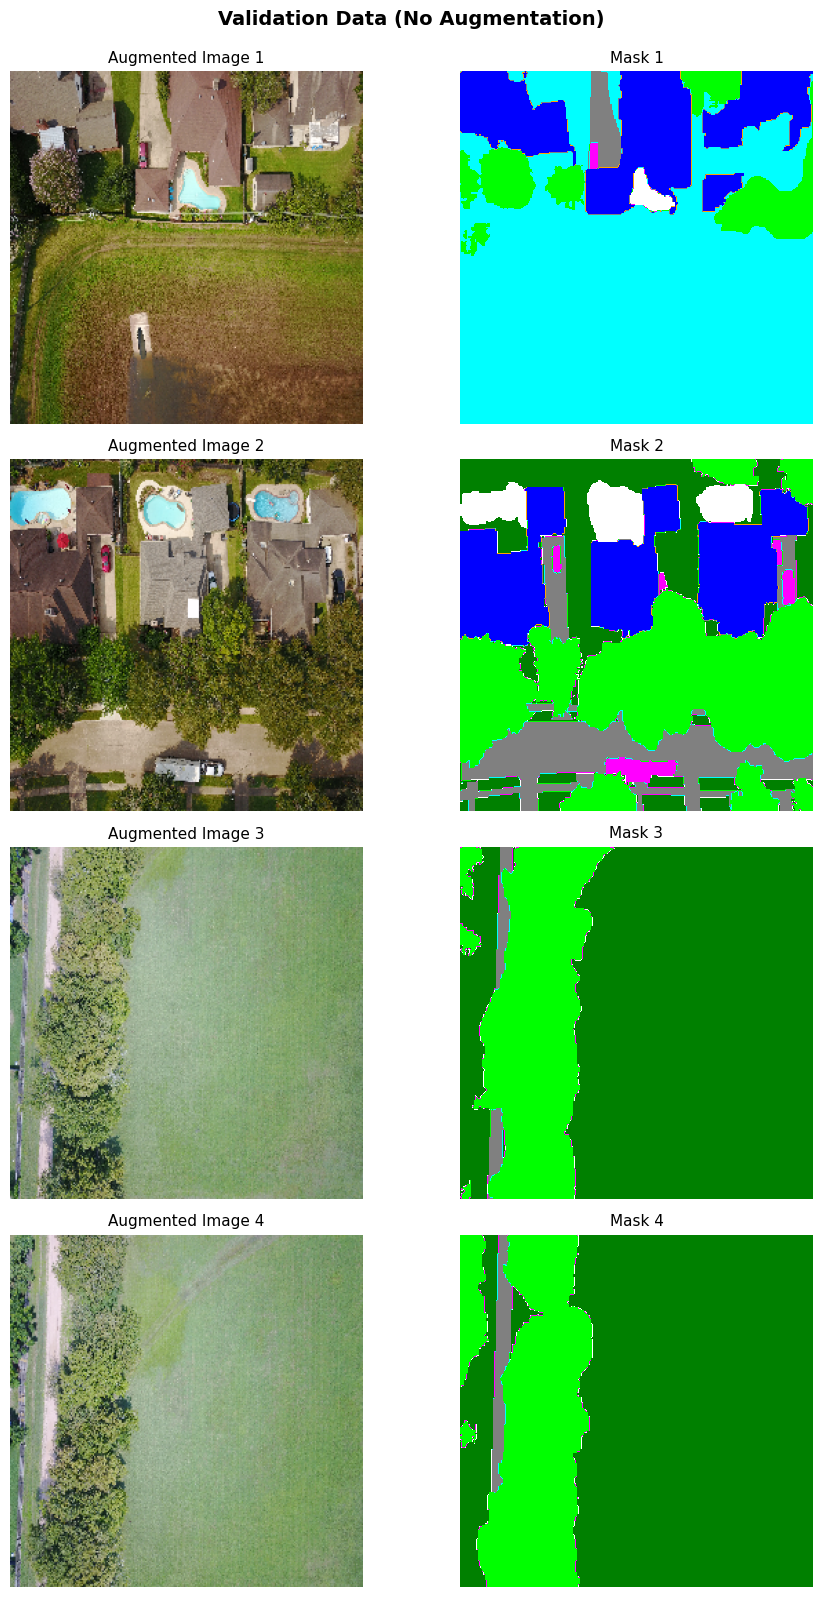

In [9]:
# ============================================================
# 9. Validation Data (No Augmentation)
# ------------------------------------------------------------
# Quick sanity visualization of validation samples (no augment).
# Uses the existing `visualize_batch` helper to display images
# and masks from the validation DataLoader.
# ============================================================

print("\n" + "=" * 60)
print("📊 VISUALIZING VALIDATION DATA (NO AUGMENTATION)")
print("=" * 60)

# Fetch one batch from validation loader (already using val transforms)
val_images, val_masks = next(iter(val_loader))

# Visualize a few validation samples and optionally save the figure
visualize_batch(
    val_images,
    val_masks,
    num_samples=4,
    title="Validation Data (No Augmentation)",
    save_path=Config.VIZ_DIR / "validation_samples.png"
)


In [10]:
# ============================================================
# 10. Summary — Preprocessing Notebook
# ------------------------------------------------------------
# Print a concise preprocessing summary, save a human-readable
# report and persist a JSON config for downstream training.
# ============================================================

# Print header
print("\n" + "=" * 70)
print("📋 PREPROCESSING SUMMARY")
print("=" * 70)

# Build a readable multi-line summary string
summary = f"""
Dataset Configuration:
{'─' * 70}
  Training Images:   {len(train_dataset):5d}
  Validation Images: {len(val_dataset):5d}
  Batch Size:        {Config.BATCH_SIZE}
  Workers:           {Config.NUM_WORKERS}
  Image Size:        {Config.IMG_HEIGHT}x{Config.IMG_WIDTH}

Data Augmentation (Training):
{'─' * 70}
  ✅ Horizontal Flip (50%)
  ✅ Vertical Flip (30%)
  ✅ Random Rotation 90° (50%)
  ✅ Shift/Scale/Rotate (50%)
  ✅ Brightness/Contrast (50%)
  ✅ Hue/Saturation/Value (50%)
  ✅ Gaussian Noise/Blur (20%)
  ✅ ImageNet Normalization

Validation (No Augmentation):
{'─' * 70}
  ✅ ImageNet Normalization only

Data Types:
{'─' * 70}
  Images:  torch.float32, shape: (B, 3, {Config.IMG_HEIGHT}, {Config.IMG_WIDTH})
  Masks:   torch.int64, shape: (B, {Config.IMG_HEIGHT}, {Config.IMG_WIDTH})
  Classes: {Config.NUM_CLASSES} (0-{Config.NUM_CLASSES-1})

Output Files:
{'─' * 70}
  ✅ {Config.VIZ_DIR / 'training_augmented_samples.png'}
  ✅ {Config.VIZ_DIR / 'validation_samples.png'}
  ✅ {Config.VIZ_DIR / 'augmentation_comparison.png'}

{'═' * 70}
✅ Preprocessing Complete!
📌 Next Step: Run notebook 03_train_unet_basic.ipynb
{'═' * 70}
"""

# Print the summary to console
print(summary)

# -------------------------
# Persist preprocessing configuration for training script
# -------------------------
preprocessing_config = {
    "img_size": (Config.IMG_HEIGHT, Config.IMG_WIDTH),
    "batch_size": Config.BATCH_SIZE,
    "num_workers": Config.NUM_WORKERS,
    "num_classes": Config.NUM_CLASSES,
    "train_samples": len(train_dataset),
    "val_samples": len(val_dataset),
    "normalization": {
        "mean": [0.485, 0.456, 0.406],
        "std": [0.229, 0.224, 0.225]
    }
}

# Save JSON config (used by training notebooks/scripts)
import json
config_path = Config.RESULTS_DIR / "preprocessing_config.json"
config_path.parent.mkdir(parents=True, exist_ok=True)  # ensure directory exists

with open(config_path, 'w', encoding='utf-8') as f:
    json.dump(preprocessing_config, f, indent=2)

print(f"\n💾 Configuration saved to: {config_path}")



📋 PREPROCESSING SUMMARY

Dataset Configuration:
──────────────────────────────────────────────────────────────────────
  Training Images:    1445
  Validation Images:   450
  Batch Size:        8
  Workers:           0
  Image Size:        256x256

Data Augmentation (Training):
──────────────────────────────────────────────────────────────────────
  ✅ Horizontal Flip (50%)
  ✅ Vertical Flip (30%)
  ✅ Random Rotation 90° (50%)
  ✅ Shift/Scale/Rotate (50%)
  ✅ Brightness/Contrast (50%)
  ✅ Hue/Saturation/Value (50%)
  ✅ Gaussian Noise/Blur (20%)
  ✅ ImageNet Normalization

Validation (No Augmentation):
──────────────────────────────────────────────────────────────────────
  ✅ ImageNet Normalization only

Data Types:
──────────────────────────────────────────────────────────────────────
  Images:  torch.float32, shape: (B, 3, 256, 256)
  Masks:   torch.int64, shape: (B, 256, 256)
  Classes: 10 (0-9)

Output Files:
──────────────────────────────────────────────────────────────────────
  ✅